# Code alongs - regularization

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 

df = pd.read_csv("../data/Advertising.csv", index_col=0)
df

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


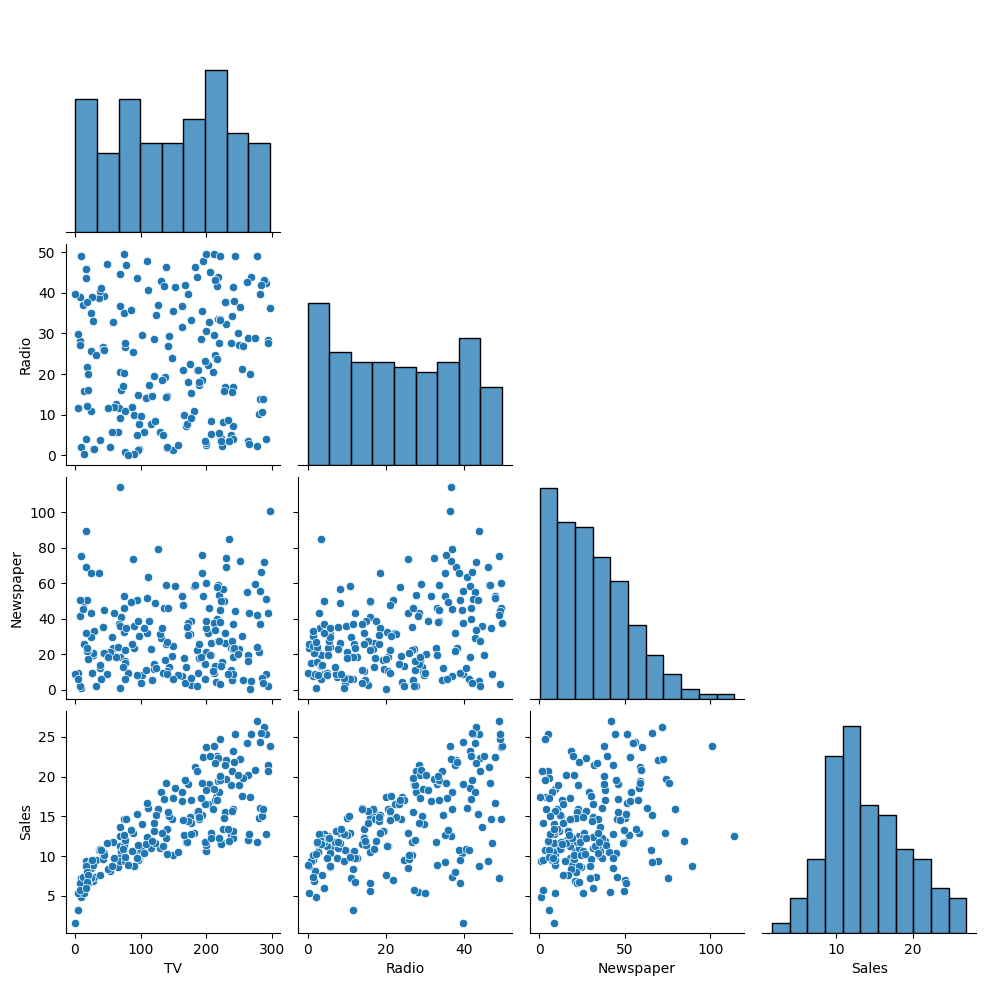

In [5]:
sns.pairplot(df, corner=True)

## Polynomial model

- increase complexity to find more patterns

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

X,y = df.drop("Sales", axis=1), df["Sales"]

X.head()

,TV,Radio,Newspaper
1,230.1,37.8,69.2
2,44.5,39.3,45.1
3,17.2,45.9,69.3
4,151.5,41.3,58.5
5,180.8,10.8,58.4


In [8]:
y[:5]

1    22.1
2    10.4
3     9.3
4    18.5
5    12.9
Name: Sales, dtype: float64

### Feature engineering
- create new features based on combinations of old features 

In [12]:
# have doen feature engineering -> now our model is very complex
# idea is to check if we get interaction effects between 
# e.g. TV and Radio or TV and Newspaper
# x1^2, x1, x2,x2^2, x3, x3^2, x1x2, x1x3, x2x3, ...
model_polynomial = PolynomialFeatures(3, include_bias=False)
poly_features = model_polynomial.fit_transform(X)
poly_features.shape

(200, 19)

## Train|test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((134, 19), (66, 19))

## Feature standardization

- scaling is neccessary for regularized models 

$X' = \frac{X-\mu}{\sigma}$

In [18]:
from sklearn.preprocessing import StandardScaler

# instantiate a scaler instance from the StandardScaler class
scaler = StandardScaler()

# gets parameters from X_train and transforms (scale) X_train
scaled_X_train = scaler.fit_transform(X_train)

# use parameters from X_train to scale X_test
# never do fit_transform on X_test since this gives data leakage
scaled_X_test = scaler.transform(X_test)

scaled_X_train.mean(), scaled_X_train.std(), scaled_X_test.mean(), scaled_X_test.std()

(-3.34898382919136e-17, 1.0, -0.11982457640326809, 1.1245966534380971)

## Regularization with k-fold cross validation

### Ridge - l2

In [20]:
from sklearn.linear_model import RidgeCV

# CV stands for Cross Validation

# cross validation with different alphas and score with MSE
model_ridge_CV = RidgeCV(
    alphas=[0.00001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10], scoring="neg_mean_squared_error"
)

model_ridge_CV.fit(scaled_X_train, y_train)
model_ridge_CV.alpha_


0.1

In [23]:
model_ridge_CV.coef_

array([ 5.84681185,  0.52142086,  0.71689997, -6.17948738,  3.75034058,
       -1.36283352, -0.08571128,  0.08322815, -0.34893776,  2.16952446,
       -0.47840838,  0.68527348,  0.63080799, -0.5950065 ,  0.61661989,
       -0.31335495,  0.36499629,  0.03328145, -0.13652471])

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model_ridge_CV.predict(scaled_X_test)

RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
MAE = mean_absolute_error(y_pred, y_test)

MAE, RMSE


(0.4343075766484079, 0.5635899169556632)

### LassoCV - l1

In [24]:
from sklearn.linear_model import LassoCV

model_lasso_CV = LassoCV(eps=0.001, n_alphas=100, max_iter=int(1e4), cv=5)
model_lasso_CV.fit(scaled_X_train, y_train)
model_lasso_CV.alpha_

0.004968802520343365

In [25]:
model_lasso_CV.coef_

array([ 5.19612354,  0.43037087,  0.29876351, -4.80417579,  3.46665205,
       -0.40507212,  0.        ,  0.        ,  0.        ,  1.35260206,
       -0.        ,  0.        ,  0.14879719, -0.        ,  0.        ,
        0.        ,  0.09649665,  0.        ,  0.04353956])

In [27]:
y_pred = model_lasso_CV.predict(scaled_X_test)

RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
MAE = mean_absolute_error(y_pred, y_test)

MAE, RMSE

(0.4629188302693299, 0.5785146895301981)

## Elastic net

- a mix between l1 and l2 regularization

In [28]:
from sklearn.linear_model import ElasticNetCV

model_elastic = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    eps=0.001,
    n_alphas=100,
    max_iter=int(1e4),
)

model_elastic.fit(scaled_X_train, y_train)
model_elastic.alpha_

0.004968802520343365

In [29]:
# l1_ratio = 1 means only l1 (lasso) and not l2 
# l1_ratio = 0 -> ridge 
# 0 < l1_ratio < 1 -> mix of l1 and l2 
model_elastic.l1_ratio_

1.0

In [30]:
model_elastic.coef_

array([ 5.19612354,  0.43037087,  0.29876351, -4.80417579,  3.46665205,
       -0.40507212,  0.        ,  0.        ,  0.        ,  1.35260206,
       -0.        ,  0.        ,  0.14879719, -0.        ,  0.        ,
        0.        ,  0.09649665,  0.        ,  0.04353956])

In [31]:
y_pred = model_elastic.predict(scaled_X_test)

RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
MAE = mean_absolute_error(y_pred, y_test)

MAE, RMSE

(0.4629188302693299, 0.5785146895301981)